<a href="https://colab.research.google.com/github/Sugandi2000/Research/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
# STEP 1 — imports, device, reproducibility
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from copy import deepcopy
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Device: cpu


In [ ]:
# STEP 2 — hyperparameters (these match your notebook defaults)
DATA_PATH = "/content/data_ecg"   # change to where you uploaded data in Colab
SIGNAL_LEN = 500                 # change if your signals are longer/shorter
NUM_CLASSES = 5                  # change to your number of classes
NUM_CLIENTS = 5
BATCH_SIZE = 64
LOCAL_EPOCHS = 2
ROUNDS = 8
LR = 0.01


# Kaggle Data Set

In [ ]:
!pip install -q kaggle
!pip install -q unzip_requirements >/dev/null 2>&1 || true

In [ ]:
from google.colab import files
uploaded = files.upload()  # upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


In [ ]:
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s ecg


ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
shayanfazeli/heartbeat                                          ECG Heartbeat Categorization Dataset                  103633768  2018-05-31 18:47:34.427000         117636        969  0.5882353        
devavratatripathy/ecg-dataset                                   ECG dataset                                             3437364  2021-01-18 06:31:17.083000          12637         78  0.5882353        
sadmansakib7/ecg-arrhythmia-classification-dataset              ECG Arrhythmia Classification Dataset                 130556591  2021-08-20 07:10:25.843000           7015         60  0.9411765    

In [ ]:
!kaggle datasets download -d danialsharifrazi/cad-cardiac-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/danialsharifrazi/cad-cardiac-mri-dataset
License(s): unknown
 98% 2.82G/2.86G [00:48<00:02, 17.3MB/s]
100% 2.86G/2.86G [00:48<00:00, 62.8MB/s]


In [ ]:
!unzip cad-cardiac-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Sick/Directory_26/SR_57/IM00059.jpg  
  inflating: Sick/Directory_26/SR_57/IM00060.jpg  
  inflating: Sick/Directory_26/SR_58/IM00001.jpg  
  inflating: Sick/Directory_26/SR_58/IM00002.jpg  
  inflating: Sick/Directory_26/SR_58/IM00003.jpg  
  inflating: Sick/Directory_26/SR_58/IM00004.jpg  
  inflating: Sick/Directory_26/SR_58/IM00005.jpg  
  inflating: Sick/Directory_26/SR_58/IM00006.jpg  
  inflating: Sick/Directory_26/SR_58/IM00007.jpg  
  inflating: Sick/Directory_26/SR_58/IM00008.jpg  
  inflating: Sick/Directory_26/SR_58/IM00009.jpg  
  inflating: Sick/Directory_26/SR_58/IM00010.jpg  
  inflating: Sick/Directory_26/SR_58/IM00011.jpg  
  inflating: Sick/Directory_26/SR_58/IM00012.jpg  
  inflating: Sick/Directory_26/SR_58/IM00013.jpg  
  inflating: Sick/Directory_26/SR_59/IM00001.jpg  
  inflating: Sick/Directory_26/SR_59/IM00002.jpg  
  inflating: Sick/Directory_26/SR_59/IM00003.jpg  
  inflating: Sick/Directory_26/

In [ ]:
import os
import zipfile

# Make a directory and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls /content


'Author Bios.docx'   cad-cardiac-mri-dataset.zip   Normal   sample_data   Sick


In [ ]:
import os
from glob import glob

# Assuming you're in the Colab default directory after unzipping
base_path = '/content/Sick'  # This is the default directory in Colab

# Recursively search for all .jpg images
image_paths = glob(os.path.join(base_path, '**', '*.jpg'), recursive=True)

# Optional: sort the image list
image_paths.sort()

In [ ]:
# Root directories
normal_root = '/content/Normal'
sick_root = '/content/Sick'

# Get all .jpg files recursively
normal_images = glob(os.path.join(normal_root, '**', '*.jpg'), recursive=True)
sick_images = glob(os.path.join(sick_root, '**', '*.jpg'), recursive=True)

# Combine and label
all_images = normal_images + sick_images
labels = [0] * len(normal_images) + [1] * len(sick_images)

print(f'Total Normal images: {len(normal_images)}')
print(f'Total Sick images: {len(sick_images)}')

Total Normal images: 37564
Total Sick images: 25861


# Data Loading

In [ ]:
import os
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
from torch.utils.data import Subset

def partition_dataset(image_paths, labels, num_partitions):
    partitions = [[] for _ in range(num_partitions)]
    label_partitions = [[] for _ in range(num_partitions)]

    for i, (path, label) in enumerate(zip(image_paths, labels)):
        partitions[i % num_partitions].append(path)
        label_partitions[i % num_partitions].append(label)

    return list(zip(partitions, label_partitions))


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('L')  # Use 'RGB' if your images are in color

        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label}

In [ ]:
def load_datasets(partition_id: int, num_partitions: int = 5):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    partitioned_data = partition_dataset(all_images, labels, num_partitions)

    image_paths_partition, labels_partition = partitioned_data[partition_id]

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths_partition, labels_partition, test_size=0.2, stratify=labels_partition, random_state=42
    )

    train_dataset = MRIDataset(train_paths, train_labels, transform=transform)
    val_dataset = MRIDataset(val_paths, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader


In [ ]:
import pandas as pd
from collections import Counter

def get_partition_df(image_paths, labels, num_partitions):
    partitions = [[] for _ in range(num_partitions)]
    label_partitions = [[] for _ in range(num_partitions)]

    for i, (path, label) in enumerate(zip(image_paths, labels)):
        partitions[i % num_partitions].append(path)
        label_partitions[i % num_partitions].append(label)

    data = []
    for pid, labels in enumerate(label_partitions):
        label_counts = Counter(labels)
        for label, count in label_counts.items():
            data.append({"partition_id": pid, "label": label, "count": count})

    return pd.DataFrame(data)

# Partition Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution(df, title="Label Distribution per Partition"):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="partition_id", y="count", hue="label")
    plt.title(title)
    plt.xlabel("Partition ID")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()


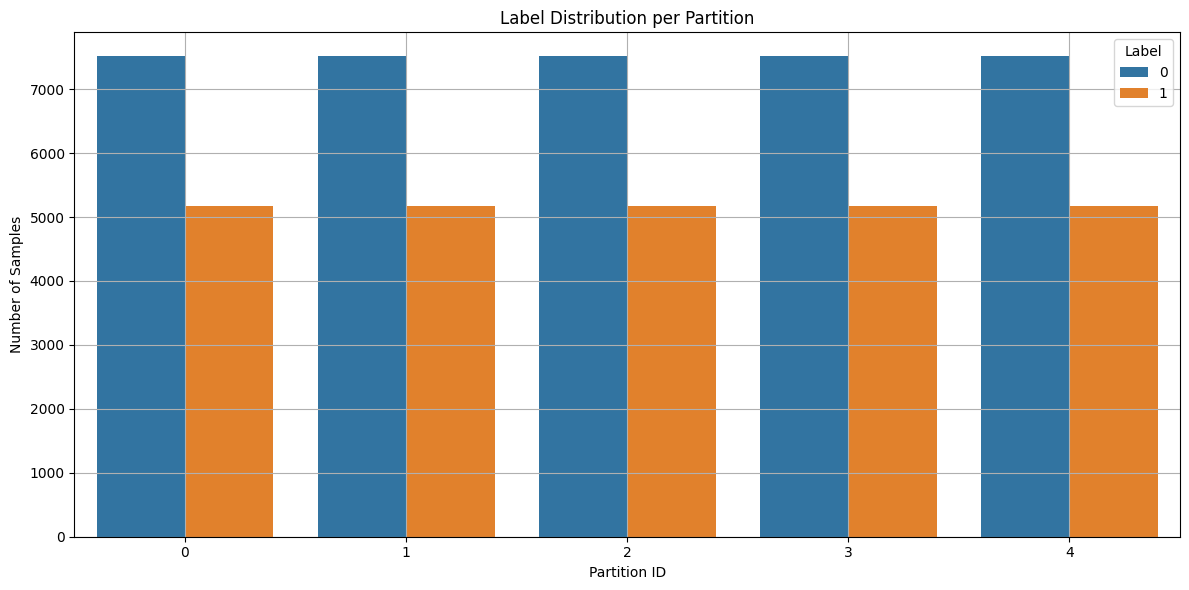

In [ ]:
partition_df = get_partition_df(all_images, labels, num_partitions=5)
plot_label_distribution(partition_df)

In [ ]:
partition_df

,partition_id,label,count
0,0,0,7513
1,0,1,5172
2,1,0,7513
3,1,1,5172
4,2,0,7513
5,2,1,5172
6,3,0,7513
7,3,1,5172
8,4,0,7512
9,4,1,5173


# New Section

In [ ]:
# ======= MLP-only code (KAN removed). Paste into your notebook =======

# required imports
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from typing import List
import numpy as np

# device and training hyperparams (if already defined in your notebook, these lines are safe duplicates)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.01
MOMENTUM = 0.9

# ---------------- MLP model (UNCHANGED) ----------------
class MLPNet(nn.Module):
    def __init__(self) -> None:
        super(MLPNet, self).__init__()
        # self.conv_layers = nn.Sequential(
        #     nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 1 input channel (grayscale), 16 output
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),  # 64x64

        #     nn.Conv2d(16, 32, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),  # 32x32
        # )
        self.fc_layers = nn.Sequential(
            nn.Linear(32*32 , 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),   # Binary classification: output logit
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

# ---------------- helper functions (kept, slightly adjusted imports present) ----------------
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_model_size_in_MB(parameters):
    total_bytes = 0
    for param in parameters:
        total_bytes += param.size * param.itemsize  # num elements * bytes per element
    return total_bytes / (1024 * 1024)  # Convert to MB

# ---------------- factory (only MLP now) ----------------
def create_network(net_type: str = "mlp"):
    if net_type == "mlp":
        return MLPNet()
    else:
        raise ValueError(f"Unknown network type: {net_type}")

# ---------------- training and testing (UNCHANGED) ----------------
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        return epoch_loss, epoch_acc

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.BCEWithLogitsLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# ===================================================================
# NOTE: If your DataLoader yields (image, label) tuples rather than dicts,
# change the two lines inside train/test loops from:
#     images, labels = batch["image"], batch["label"]
# to:
#     images, labels = batch
#
# I left them as-is to match your original code.
# ===================================================================


# New Section

In [ ]:
!pip install -q flwr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.0/732.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography

In [ ]:
import flwr as fl
from flwr.common import FitRes, EvaluateRes, Parameters
from flwr.client import NumPyClient

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
